In [1]:
import os
import json
import random
import numpy as np

# For results reproducibility: setting seeds and deterministic ops before importing TensorFlow
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

import tensorflow as tf
from tensorflow import keras

# Set seeds across libraries
random.seed(SEED)
np.random.seed(SEED)
try:
    tf.keras.utils.set_random_seed(SEED)
except Exception:
    tf.random.set_seed(SEED)

# Optional: force CPU for stricter determinism (uncomment to enable)
# try:
#     tf.config.set_visible_devices([], 'GPU')
# except Exception:
#     pass

# Constrain threading to avoid nondeterministic scheduling
try:
    tf.config.threading.set_intra_op_parallelism_threads(1)
    tf.config.threading.set_inter_op_parallelism_threads(1)
except Exception:
    pass

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import time
import datetime


In [2]:
# !pip list |grep tensorflow

# Data Loading & Preparation:

In [3]:

def check_data_continuity(data_set):
    for i in range(1, len(data_set)):
        assert data_set.index[i] > data_set.index[i-1]


In [4]:
# 1. Data Loading and Preparation
file_path = "./data/DWH/new_features_5min_csv/part-00000-ad0eaf40-3913-4896-b4cd-7d402a566e01-c000.csv"
df = pd.read_csv(file_path, index_col="t_trade_epoch")

# 2. Feature Selection - in Feature_Selection notebook
features = ['m_avg_snp_media_events_count_last_3days', 'm_stddev_snp_media_events_count_last_7days', 'p_avg_close_price_for_last_50min', 'p_min_high_price_for_last_25min', 'p_stddev_open_price_for_last_50min', 'p_max_high_price_for_last_15min', 'p_max_high_price_for_last_25min', 'p_min_close_price_for_last_50min', 'm_stddev_snp_media_events_count_last_14days', 'm_sum_snp_media_events_count_last_60days', 'm_sum_snp_media_events_count_last_30min', 'p_max_low_price_for_last_50min', 'p_avg_volume_price_for_last_50min', 'm_stddev_snp_media_events_count_last_15min', 't_precent_of_time_from_start_of_trade_day', 'm_avg_snp_media_events_count_last_30min', 'm_sum_snp_media_events_count_last_3days', 'p_min_volume_price_for_last_15min', 'm_stddev_snp_media_events_count_last_30days', 'm_max_snp_media_events_count_last_14days', 'p_min_low_price_for_last_25min', 'm_sum_snp_media_events_count_last_30days', 'p_avg_high_price_for_last_25min', 'p_stddev_high_price_for_last_50min', 't_precent_of_time_from_start_of_trade_pase', 't_trade_open_e', 'p_avg_low_price_for_last_25min', 'p_max_open_price_for_last_50min', 't_time_diff_between_trade_and_trade_part_open_in_sec', 't_trade_day_of_week', 'm_sum_snp_media_events_count_last_3hour', 't_trade_hour', 'p_min_low_price_for_last_15min', 'p_max_close_price_for_last_50min', 'p_max_volume_price_for_last_50min', 'm_avg_snp_media_events_count_last_7days', 'm_avg_snp_media_events_count_last_60days', 'p_min_volume_price_for_last_50min', 'p_stddev_low_price_for_last_50min', 'm_max_snp_media_events_count_last_60days', 'p_min_open_price_for_last_25min', 't_trade_part', 'm_avg_snp_media_events_count_last_1hour', 'p_max_low_price_for_last_15min', 'p_min_close_price_for_last_25min', 't_trade_part_open_e', 'p_avg_open_price_for_last_50min', 'p_min_low_price_for_last_50min', 'p_min_open_price_for_last_50min', 't_time_diff_between_trade_and_open_in_sec', 't_trade_close_e', 'm_max_snp_media_events_count_last_3days', 'm_stddev_snp_media_events_count_last_3hour', 'm_max_snp_media_events_count_last_7days', 't_trade_minute', 'm_max_snp_media_events_count_last_30days', 'm_sum_snp_media_events_count_last_7days', 'm_sum_snp_media_events_count_last_45min', 'p_min_high_price_for_last_50min', 'm_max_snp_media_events_count_last_3hour', 'p_min_high_price_for_last_15min', 'p_stddev_close_price_for_last_50min', 'high', 'm_avg_snp_media_events_count_last_30days', 'm_avg_snp_media_events_count_last_45min', 'm_stddev_snp_media_events_count_last_3days', 'm_max_snp_media_events_count_last_1hour', 'm_sum_snp_media_events_count_last_1hour', 'p_max_low_price_for_last_25min', 'open', 't_trade_part_open_h', 'p_stddev_volume_price_for_last_50min', 'm_stddev_snp_media_events_count_last_45min', 'p_avg_high_price_for_last_15min', 'p_max_open_price_for_last_25min', 'm_sum_snp_media_events_count_last_14days', 'p_max_close_price_for_last_25min', 'm_stddev_snp_media_events_count_last_60days', 'm_avg_snp_media_events_count_last_14days', 'm_avg_snp_media_events_count_last_3hour', 'p_avg_low_price_for_last_50min', 'low', 'm_stddev_snp_media_events_count_last_1hour', 'p_min_volume_price_for_last_25min']
target = 'close'

# 3. Use chosen features + target, drop rows with any NaN
data = df[features + [target]].dropna()
print(f"rows with any NaN drop - {df.shape[0] - data.shape[0]}")

check_data_continuity(data)


rows with any NaN drop - 0


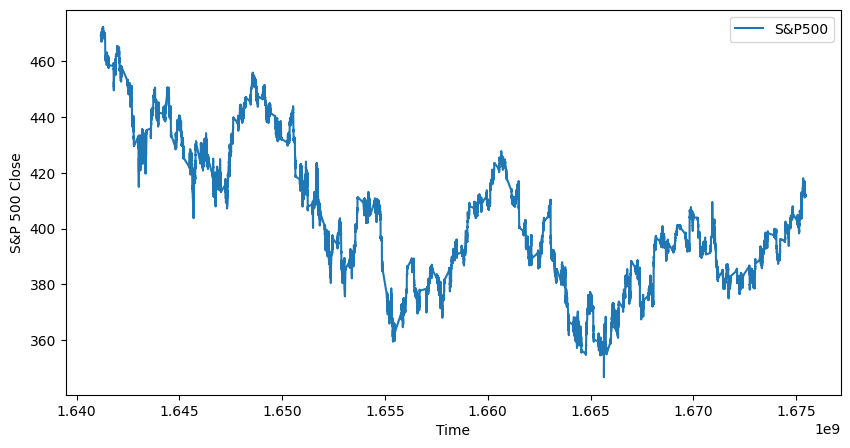

In [5]:
# 4. Plot S&P500 Close price
plt.figure(figsize=(10, 5))
plt.plot(data.index, data["close"], label="S&P500")
plt.xlabel("Time")
plt.ylabel("S&P 500 Close")
plt.legend()
plt.show()

In [6]:
# 5. Split to train and test
train_ratio = 0.8
test_ratio = 0.2

# Calculate the split points based on the desired ratios
train_size = round(len(data) * train_ratio)
test_size = round(len(data) * test_ratio)
assert train_size + test_size == len(data)

train_data = data[0:train_size]
train_labels = pd.DataFrame(train_data, columns=['close'])
train_data = train_data.drop(['close'], axis=1)

test_data = data[train_size: (train_size + test_size)]
test_labels = pd.DataFrame(test_data, columns=['close'])
test_data = test_data.drop(['close'], axis=1)

In [7]:
# 6. Check each set (train, test)
check_data_continuity(train_data)
check_data_continuity(train_labels)

check_data_continuity(test_data)
check_data_continuity(test_labels)

# Verify set sizes
assert len(train_data) == train_size
assert len(train_labels) == train_size
assert len(test_data) == test_size
assert len(test_labels) == test_size

# Check for overlap
assert len(set(train_data.index).intersection(set(test_data.index))) == 0


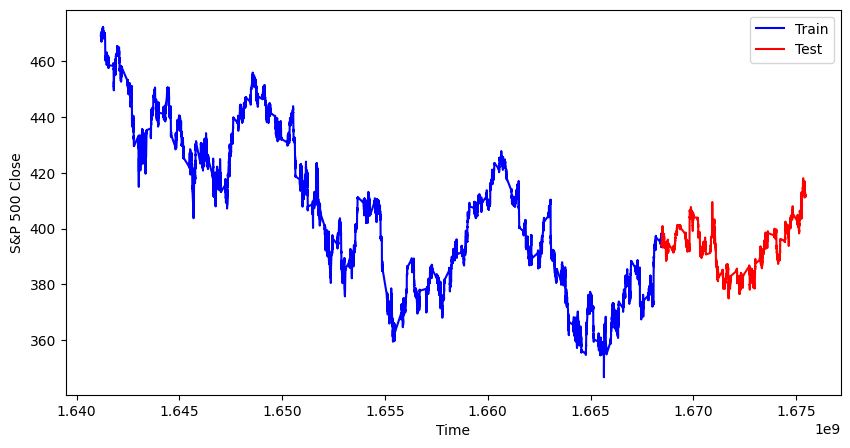

In [8]:

# 7. Plot S&P500 Close price with train and test split
plt.figure(figsize=(10, 5))
plt.plot(train_labels.index, train_labels["close"], label="Train", color="blue")
plt.plot(test_labels.index, test_labels["close"], label="Test", color="red")
plt.xlabel("Time")
plt.ylabel("S&P 500 Close")
plt.legend()
plt.show()


In [9]:
# 8. Data Preprocessing
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# drop the last row to align with next-step label
X_train_scaled = scaler_X.fit_transform(train_data.values[:-1])
X_test_scaled = scaler_X.transform(test_data.values[:-1])

# next-step delta targets
y_train_raw = train_labels['close'].diff().shift(-1).dropna().values.reshape(-1, 1)
y_test_raw = test_labels['close'].diff().shift(-1).dropna().values.reshape(-1, 1)

y_train_scaled = scaler_y.fit_transform(y_train_raw)
y_test_scaled = scaler_y.transform(y_test_raw)

# Verify set sizes
assert len(X_train_scaled) == len(y_train_scaled) == train_size-1
assert len(X_test_scaled) == len(y_test_scaled) == test_size-1
assert len(X_train_scaled) + len(X_test_scaled) == train_size + test_size -2 == len(data)-2

print(f"{X_train_scaled.shape=}")
print(f"{y_train_scaled.shape=}")
print(f"{X_test_scaled.shape=}")
print(f"{y_test_scaled.shape=}")


X_train_scaled.shape=(41805, 84)
y_train_scaled.shape=(41805, 1)
X_test_scaled.shape=(10451, 84)
y_test_scaled.shape=(10451, 1)


In [10]:
# 9. Prepare Data for LSTM: Create sequences
def create_sequences(X, y, lookback):  
    """Creates input sequences for LSTM."""
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        v = X[i:(i + lookback)]
        Xs.append(v)
        ys.append(y[i + lookback])
    return np.array(Xs), np.array(ys)

lookback = 20
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, lookback)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, lookback)

num_features = X_train_seq.shape[2]


print(f"{X_train_seq.shape=}")
print(f"{y_train_seq.shape=}")
print(f"{X_test_seq.shape=}")
print(f"{y_test_seq.shape=}")
print(f"----------------------")



X_train_seq.shape=(41785, 20, 84)
y_train_seq.shape=(41785, 1)
X_test_seq.shape=(10431, 20, 84)
y_test_seq.shape=(10431, 1)
----------------------


# Train Or Load Already Traind Model (Update training_flag)

In [11]:
# 14. Make predictions and invert scaling

def predict_close_price(model, df):
    # Measure Inference Time
    start_pred_time = time.time()

    # Predict scaled deltas
    y_test_pred_scaled = model.predict(X_test_seq)

    end_pred_time = time.time()
    total_inference_time = end_pred_time - start_pred_time
    avg_inference_time_ms = (total_inference_time / len(X_test_seq)) * 1000

    # Inverse-transform deltas
    y_test_pred_delta = scaler_y.inverse_transform(y_test_pred_scaled)  # shape (N,1)
    y_test_true_delta = scaler_y.inverse_transform(y_test_seq)          # shape (N,1)

    # Reconstruct price path from last close in each lookback window
    # Need the corresponding last observed close at the end of each input window
    # For test set, source the unscaled close array aligned with X_test_raw

    test_df = df.shift(-1).dropna()
    close_test = test_df['close'].values

    # The last close for each sequence ends at index i+lookback-1
    last_close_in_window = close_test[lookback-1: -1]  # length aligns with sequences count

    # Predicted next close = last_close + predicted_delta
    predicted_close = last_close_in_window + y_test_pred_delta.squeeze()
    true_next_close = last_close_in_window + y_test_true_delta.squeeze()

    print(f"predicted_close shape: {predicted_close.shape}")

    # Build result frame aligned to test_df indices after lookback
    res_idx = test_df.index[lookback: lookback + len(predicted_close)]
    res_df = pd.DataFrame({
        'close': true_next_close,
        'predicted_close_price': predicted_close
    }, index=res_idx)


    start_pred_time_formatted = datetime.datetime.fromtimestamp(start_pred_time).strftime('%d/%m/%Y %H:%M:%S')
    end_pred_time_formatted = datetime.datetime.fromtimestamp(end_pred_time).strftime('%d/%m/%Y %H:%M:%S')

    print("---------------------------------------------------------")
    print(f"Start Time: {start_pred_time_formatted}")
    print(f"End Time:   {end_pred_time_formatted}")
    print(f"Total Inference Time: {total_inference_time:.2f} seconds")
    print(f"Avg Inference Time: {avg_inference_time_ms:.2f} ms")
    print("---------------------------------------------------------")

    return res_df, y_test_pred_delta, total_inference_time, avg_inference_time_ms



In [12]:
import json

def read_evaluation_metrics_files(files_list):
    evaluation_metrics = []
    for file in files_list:
        try:
            with open(file, 'r') as json_file:
                evaluation_metrics.append(json.load(json_file))
        #     print("\nData read back from file:")
        #     print(loaded_data)
        except IOError as e:
            print(f"Error reading from file {file}: {e}")
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON from file {file}: {e}")
    return evaluation_metrics

In [13]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.layers import BatchNormalization

########################### IMPORTENT DON'T FORGET TO UPDATE training_flag ###########################
# I you want to retrain the model Set training_flag = True
training_flag = False
old_model_version = "14_09_2025_00_05"
old_model_file_name = "model_Loss_0.00055608_MAE_0.23340367.keras"

if training_flag:

    # 10. Initiate the LSTM NN
    DROPOUT_RATE = 0.3
    L2_REG_STRENGTH = 0.001

    model = keras.Sequential([
        keras.layers.LSTM(
            units=100,
            return_sequences=True,
            input_shape=(lookback, num_features),
            dropout=DROPOUT_RATE,
            recurrent_dropout=DROPOUT_RATE,
            kernel_regularizer=l2(L2_REG_STRENGTH)
        ),
        BatchNormalization(),

        keras.layers.LSTM(
            units=50,
            return_sequences=False,
            dropout=DROPOUT_RATE,
            recurrent_dropout=DROPOUT_RATE,
            kernel_regularizer=l2(L2_REG_STRENGTH)
        ),
        BatchNormalization(),

        keras.layers.Dense(units=25, activation='relu'),

        keras.layers.Dense(units=1)
    ])

    # 11. Compile the Model
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    # Define Early Stopping - Stop training if validation loss doesn't improve for 5 consecutive epochs,
    # and restore the weights from the epoch with the best validation loss
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # 12. Train the Model
    start_time = time.time()
    epochs = 50  # We can set a higher number now, EarlyStopping will find the best one
    batch_size = 64
    history = model.fit(
        X_train_seq,
        y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_seq, y_test_seq),
        verbose=2,
        shuffle=False,  # This is CRITICAL for time-series data
        callbacks=[early_stopping] # Activate early stopping
    )

    end_time = time.time()
    training_time_seconds = end_time - start_time


    # 13. Evaluate the Model
    loss, mae = model.evaluate(X_test_seq, y_test_seq, verbose=0)

    start_time_formatted = datetime.datetime.fromtimestamp(start_time).strftime('%d/%m/%Y %H:%M:%S')
    end_time_formatted = datetime.datetime.fromtimestamp(end_time).strftime('%d/%m/%Y %H:%M:%S')

    print("---------------------------------------------------------")
    print(f"Start Time: {start_time_formatted} \nEnd Time:   {end_time_formatted} \nTraining Time: {training_time_seconds:.2f} seconds")
    print("---------------------------------------------------------")
    print(f"Validation Loss: {loss:.8f} \nValidation MAE:  {mae:.8f}")
    print("---------------------------------------------------------")

# load allready trained LSTM network
else:

    # Load Saved LSTM NN And Predict
    project_path = os.getcwd()
    trained_models_path = f"{project_path}/data/trained_models"
    trained_model_version_path = f"{trained_models_path}/5_min/{old_model_version}"

    model = keras.saving.load_model(f"{trained_model_version_path}/{old_model_file_name}")

    # Load training_time_seconds from lstm_evaluation_metrics.json
    lstm_evaluation_metrics = read_evaluation_metrics_files(files_list=[f"{trained_model_version_path}/lstm_evaluation_metrics.json"])
    training_time_seconds = float(lstm_evaluation_metrics[0]["Computational_Efficiency"]["Training_Time"].replace(" seconds",""))



In [14]:
# Predict close price
res_df, y_test_pred_delta, total_inference_time, avg_inference_time_ms = predict_close_price(model=model,
                                                                                             df=test_labels)


326/326 [==============================] - 2s 5ms/step
predicted_close shape: (10431,)
---------------------------------------------------------
Start Time: 18/09/2025 15:19:47
End Time:   18/09/2025 15:19:49
Total Inference Time: 1.74 seconds
Avg Inference Time: 0.17 ms
---------------------------------------------------------


In [ ]:
# 16. Calculate Comprehensive Evaluation Metrics

print("\n" + "="*80)
print("LSTM 5-Minute Model - Comprehensive Evaluation Metrics")
print("="*80 + "\n")

# Prediction Accuracy Metrics
print("🎯 Prediction Accuracy Metrics")
print("-" * 40)

mae = np.mean(np.abs(res_df['predicted_close_price'] - res_df['close']))
mse = mean_squared_error(res_df['close'], res_df['predicted_close_price'])
rmse = np.sqrt(mse)

# Directional Accuracy
res_df['actual_change'] = res_df['close'].diff()
res_df['predicted_change'] = res_df['predicted_close_price'].diff()
res_df['same_direction'] = np.sign(res_df['actual_change']) == np.sign(res_df['predicted_change'])
directional_accuracy = res_df['same_direction'].iloc[1:].mean()

print(f"MAE (Mean Absolute Error): {mae:.4f}")
print(f"RMSE (Root Mean Square Error): {rmse:.4f}")
print(f"Directional Accuracy: {directional_accuracy:.2%}")

# Computational Efficiency Metrics
print(f"\n⚡ Computational Efficiency Metrics")
print("-" * 40)
print(f"Training Time: {training_time_seconds:.2f} seconds ({training_time_seconds/60:.2f} minutes)")
print(f"Average Inference Time: {avg_inference_time_ms:.4f} ms/prediction")
print(f"Total Predictions Made: {len(y_test_pred_delta):,}")

# Trading Simulation Metrics
print(f"\n💰 Simple Trading Simulation Metrics")
print("-" * 40)

# Calculate the close_price_predicted_percentage_change
res_df['close_price_predicted_percentage_change'] = ((res_df['predicted_close_price'] - res_df['close']) / res_df['close']) * 100

# Trading Rules:
# If close_price_predicted_percentage_change >= 0.225% BUY
# If close_price_predicted_percentage_change <= -0.225% SELL
# Else HOLD
res_df['action'] = np.where(res_df['close_price_predicted_percentage_change'] >= 0.225, 'BUY',
                            np.where(res_df['close_price_predicted_percentage_change'] <= -0.225, 'SELL', 'HOLD'))

# Trading simulation
initial_capital = 10000.00
cash = initial_capital
holdings = 0.00
portfolio_value = []

for i in range(len(res_df)):
    close_price = res_df['close'].iloc[i]

    if res_df['action'].iloc[i] == 'BUY' and cash > 0:
        holdings = cash / close_price
        cash = 0
    elif res_df['action'].iloc[i] == 'SELL' and holdings > 0:
        cash = holdings * close_price
        holdings = 0

    portfolio_value.append(cash + holdings * close_price)

res_df['portfolio_value'] = portfolio_value

# Calculate trading metrics
final_portfolio_value = res_df['portfolio_value'].iloc[-1]
profit = final_portfolio_value - initial_capital
cumulative_return_pct = (profit / initial_capital) * 100

# Define the list of values to check against
actions = ["BUY", "SELL"]
tmp_res_df = pd.DataFrame(np.sign(res_df.loc[res_df["action"].isin(actions), "actual_change"]) == np.sign(res_df.loc[res_df["action"].isin(actions), "predicted_change"]),
                  columns=["simulation_same_direction"])
simulation_directional_accuracy = tmp_res_df['simulation_same_direction'].iloc[1:].mean()

# Portfolio returns for Sharpe ratio calculation
res_df['portfolio_return'] = res_df['portfolio_value'].pct_change().fillna(0)

# Sharpe Ratio (annualized, assuming 252 trading days, 8 hours, 60 minutes)
if res_df['portfolio_return'].std() != 0:
    trading_minutes_per_year = 252 * 8 * 60
    avg_return = res_df['portfolio_return'].mean()
    return_std = res_df['portfolio_return'].std()
    sharpe_ratio = (avg_return / return_std) * np.sqrt(trading_minutes_per_year)
else:
    sharpe_ratio = 0.0

# Maximum Drawdown
running_max = res_df['portfolio_value'].cummax()
drawdown = (res_df['portfolio_value'] - running_max) / running_max
max_drawdown = drawdown.min()

# Trading statistics
total_trades = len(res_df[res_df['action'] != 'HOLD'])
buy_trades = len(res_df[res_df['action'] == 'BUY'])
sell_trades = len(res_df[res_df['action'] == 'SELL'])
hold_trades = len(res_df[res_df['action'] == 'HOLD'])

print(f"Initial Capital: ${initial_capital:,.2f}")
print(f"Final Portfolio Value: ${final_portfolio_value:,.2f}")
print(f"Total Profit/Loss: ${profit:,.2f}")
print(f"Cumulative Return: {cumulative_return_pct:.2f}%")
print(f"Sharpe Ratio (Annualized): {sharpe_ratio:.3f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Total Trading Actions: {total_trades:,}")
print(f"  - BUY signals: {buy_trades:,}")
print(f"  - SELL signals: {sell_trades:,}")
print(f"  - HOLD periods: {hold_trades:,}")
print(f"Simulation_Directional_Accuracy: {simulation_directional_accuracy:.2%}")

# 17. Print Consolidated Metrics Summary
metrics_results = {
    "Data_Resolution": "5min",
    "Prediction_Accuracy": {
        "MAE": mae,
        "RMSE": rmse,
        "Directional_Accuracy": f"{directional_accuracy:.2%}"
    },
    "Computational_Efficiency": {
        "Training_Time": f"{training_time_seconds:.2f} seconds",
        "Average_Inference_Time": f"{avg_inference_time_ms:.4f} ms/prediction",
        "Total_Predictions_Made": f"{len(y_test_pred_delta):,}"
    },
    "Trading_Simulation": {
        "Initial_Capital": f"${initial_capital:,.2f}",
        "Final_Portfolio_Value": f"${final_portfolio_value:,.2f}",
        "Cumulative_Return": f"{cumulative_return_pct:.2f}%",
        "Sharpe_Ratio_Annualized": f"{sharpe_ratio:.3f}",
        "Maximum_Drawdown": f"{max_drawdown:.2%}",
        "Total_Trades": total_trades,
        "BUY_signals": buy_trades,
        "SELL_signals": sell_trades,
        "HOLD_periods": hold_trades,
        "Simulation_Directional_Accuracy": f"{simulation_directional_accuracy:.2%}"
    }
}

# print(f"\n📊 SUMMARY METRICS (JSON FORMAT)")
# print("-" * 40)
# import json
# print(json.dumps(metrics_results, indent=4))

# ================================================================================
# LSTM 5-Minute Model - Comprehensive Evaluation Metrics
# ================================================================================

# 🎯 Prediction Accuracy Metrics
# ----------------------------------------
# MAE (Mean Absolute Error): 0.2334
# RMSE (Root Mean Square Error): 0.3630
# Directional Accuracy: 47.01%

# ⚡ Computational Efficiency Metrics
# ----------------------------------------
# Training Time: 667.82 seconds (11.13 minutes)
# Average Inference Time: 0.1970 ms/prediction
# Total Predictions Made: 10,431

# 💰 Simple Trading Simulation Metrics
# ----------------------------------------
# Initial Capital: $10,000.00
# Final Portfolio Value: $10,728.47
# Total Profit/Loss: $728.47
# Cumulative Return: 7.28%
# Sharpe Ratio (Annualized): 3.404
# Maximum Drawdown: -7.42%
# Total Trading Actions: 254
#   - BUY signals: 172
#   - SELL signals: 82
#   - HOLD periods: 10,177
# Simulation_Directional_Accuracy: 54.94%


In [ ]:
# 17.Passive Simulation (Buy and Hold) Metrics
print(f"\n💰 Passive Investing (Buy and Hold) Trading Simulation Metrics")
print("-" * 40)

# Calculate trading metrics
initial_close_price = res_df.iloc[0]["close"]
final_close_price = res_df.iloc[-1]["close"]
passive_investing_cumulative_return = ((final_close_price - initial_close_price)/initial_close_price)

# Passive returns for Sharpe ratio calculation
res_df['passive_return'] = res_df['close'].pct_change().fillna(0)

# Sharpe Ratio (annualized, assuming 252 trading days, 8 hours, 60 minutes)
if res_df['passive_return'].std() != 0:
    trading_minutes_per_year = 252 * 8 * 60
    avg_return = res_df['passive_return'].mean()
    return_std = res_df['passive_return'].std()
    passive_investing_sharpe_ratio = (avg_return / return_std) * np.sqrt(trading_minutes_per_year)
else:
    passive_investing_sharpe_ratio = 0.0

final_passive_portfolio_value = initial_capital *( 1 + passive_investing_cumulative_return)

# Maximum Drawdown
p_running_max = res_df['close'].cummax()
p_drawdown = (res_df['close'] - running_max) / running_max
p_max_drawdown = drawdown.min()
p_total_trades = 1
p_buy_trades = 1
p_sell_trades = 0
p_hold_trades = len(res_df) - (p_buy_trades + p_sell_trades)


print(f"Initial Capital: ${initial_capital:,.2f}")
print(f"Final Portfolio Value: ${final_passive_portfolio_value:,.2f}")
print(f"Total Profit/Loss: ${final_passive_portfolio_value - initial_capital:,.2f}")
print(f"Cumulative Return: {passive_investing_cumulative_return * 100:.2f}%")
print(f"Sharpe Ratio (Annualized): {passive_investing_sharpe_ratio:.3f}")
print(f"Maximum Drawdown: {p_max_drawdown:.2%}")
print(f"Total Trading Actions: {p_total_trades:,}")
print(f"  - BUY signals: {p_buy_trades:,}")
print(f"  - SELL signals: {p_sell_trades:,}")
print(f"  - HOLD periods: {p_hold_trades:,}")

# 17. Print Consolidated Metrics Summary
passive_metrics_results = {
    "Data_Resolution": "5min",
    "Initial_Close_Price": f"{initial_close_price:.2f}",
    "Final_Close_Price": f"{final_close_price:.2f}",
    "Initial_Capital": f"${initial_capital:,.2f}",
    "Final_Portfolio_Value": f"${final_passive_portfolio_value:,.2f}",
    "Cumulative_Return": f"{passive_investing_cumulative_return * 100:.2f}%",
    "Sharpe_Ratio_Annualized": f"{passive_investing_sharpe_ratio:.3f}",
    "Maximum_Drawdown": f"{p_max_drawdown:.2%}",
    "Total_Trades": p_total_trades,
    "BUY_signals": p_buy_trades,
    "SELL_signals": p_sell_trades,
    "HOLD_periods": p_hold_trades
}

# print(f"\n📊 SUMMARY METRICS (JSON FORMAT)")
# print("-" * 40)
# import json
# print(json.dumps(metrics_results, indent=4))

# 💰 Passive Investing (Buy and Hold) Trading Simulation Metrics
# ----------------------------------------
# Initial Capital: $10,000.00
# Final Portfolio Value: $10,385.95
# Total Profit/Loss: $385.95
# Cumulative Return: 3.86%
# Sharpe Ratio (Annualized): 1.604
# Maximum Drawdown: -7.42%
# Total Trading Actions: 1
#   - BUY signals: 1
#   - SELL signals: 0
#   - HOLD periods: 10,430

In [ ]:
# 18. Plotting Results
print("\n" + "="*50)
print("Plotting Results")
print("="*50 + "\n")

# Plot the actual vs. predicted close values for a sample
sample_ratio = 0.1
first_n_rows = int(len(res_df) * sample_ratio)
print(f"Plotting first {first_n_rows} rows for clarity...")

plt.figure(figsize=(14, 7))
plt.plot(res_df.index[:first_n_rows], res_df['close'].iloc[:first_n_rows], label='Actual Close', color='blue')
plt.plot(res_df.index[:first_n_rows], res_df['predicted_close_price'].iloc[:first_n_rows], label='Predicted Close', color='green', linestyle='--')
plt.xlabel('Time (Epoch)')
plt.ylabel('S&P 500 Close Price')
plt.title('Actual vs. Predicted Close Prices (Sample)')
plt.legend()
plt.grid(True)
plt.show()

# Plot the portfolio value over time
plt.figure(figsize=(14, 7))
plt.plot(res_df.index, res_df['portfolio_value'], label='Portfolio Value', color='purple')
plt.xlabel('Time (Epoch)')
plt.ylabel('Portfolio Value ($)')
plt.title('Trading Simulation Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()




In [18]:
import datetime
import os.path

# 19. Save LSTM NN

def create_directory_if_not_exists(path):
  """Creates a directory if it doesn't exist, handling existing files gracefully.
  """
  if os.path.exists(path):
    if os.path.isfile(path):
      print(f"Error: '{path}' is an existing file, not a directory.")
      return False # Indicate failure
    else: # Directory exists
      print(f"Directory '{path}' already exists.")
      return True # Indicate success - the directory exists
  else: # Path doesn't exist
    try:
      os.makedirs(path)
      print(f"Directory '{path}' created successfully.")
      return True # Success
    except OSError as e:
      print(f"Error creating directory '{path}': {e}")
      return False # Failure


In [19]:
def get_current_datetime_formatted():
    """Returns the current date and time formatted as dd/mm/yyyy hh:mm."""
    now = datetime.datetime.now()
    formatted_datetime = now.strftime("%d_%m_%Y_%H_%M")
    return formatted_datetime


In [20]:
def write_json_file(file_path, json_content):
    # Writing to a JSON file
    try:
        with open(file_path, 'w') as json_file:
            json.dump(json_content, json_file, indent=4)
        print(f"Data successfully written to {file_path}")
    except IOError as e:
        print(f"Error writing to file {file_path}: {e}")

    # Optional: Reading the data back to verify
    try:
        with open(file_path, 'r') as json_file:
            loaded_data = json.load(json_file)
    #     print("\nData read back from file:")
    #     print(loaded_data)
    except IOError as e:
        print(f"Error reading from file {file_path}: {e}")
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON from file {file_path}: {e}")


# Save new Trained Model (Update save_model_flag)

In [21]:
save_model_flag = False


cwd = os.getcwd()
# print(f"{cwd=}")


if save_model_flag:

    # Get the formatted date and time
    current_datetime = get_current_datetime_formatted()
    # print(current_datetime)

    # direct to 1_min results
    trained_model_folder = f"{cwd}/data/trained_models/5_min/{current_datetime}"
    # print(f"{trained_model_folder=}")

    trained_model_full_path = f"{trained_model_folder}/model_Loss_{loss:.8f}_MAE_{mae:.8f}.keras"

    create_directory_if_not_exists(trained_model_folder)


    model.save(filepath=trained_model_full_path)

    print(f"Model Storage Location - \"{trained_model_full_path}\"")


    print(f"Reloading Model From Storage Location - \"{trained_model_full_path}\"")

    loaded_model = keras.saving.load_model(trained_model_full_path)

    res_df, y_test_pred_delta, total_inference_time, avg_inference_time_ms = predict_close_price(model=loaded_model, df=test_labels)

else:
    print(f"This model was already saved - {trained_model_version_path}")

This model was already saved - /Users/ybatash/Workspace/tau.ac.il/tau-final-project/data/trained_models/5_min/14_09_2025_00_05


In [22]:
save_or_overwrite = "overwrite"

if save_or_overwrite == "save":
    print("Saving new metrics files")
    # Save LSTM metrics_results Json
    lstm_evaluation_metrics_file_name = f"{trained_model_folder}/lstm_evaluation_metrics.json"
    write_json_file(file_path=lstm_evaluation_metrics_file_name, json_content=metrics_results )

    # Save Passive metrics_results Json
    passive_evaluation_metrics_file_name = f"{trained_model_folder}/passive_evaluation_metrics.json"
    write_json_file(file_path=passive_evaluation_metrics_file_name, json_content=passive_metrics_results )
elif save_or_overwrite == "overwrite":
    print("Overwrite old files")
    # Save LSTM metrics_results Json
    write_json_file(file_path=f"{trained_model_version_path}/lstm_evaluation_metrics.json",
                    json_content=metrics_results )

    # Save Passive metrics_results Json
    write_json_file(file_path=f"{trained_model_version_path}/passive_evaluation_metrics.json",
                    json_content=passive_metrics_results )
else:
    print("Not saved or overwrite")

Overwrite old files
Data successfully written to /Users/ybatash/Workspace/tau.ac.il/tau-final-project/data/trained_models/5_min/14_09_2025_00_05/lstm_evaluation_metrics.json
Data successfully written to /Users/ybatash/Workspace/tau.ac.il/tau-final-project/data/trained_models/5_min/14_09_2025_00_05/passive_evaluation_metrics.json


first_n_rows=52


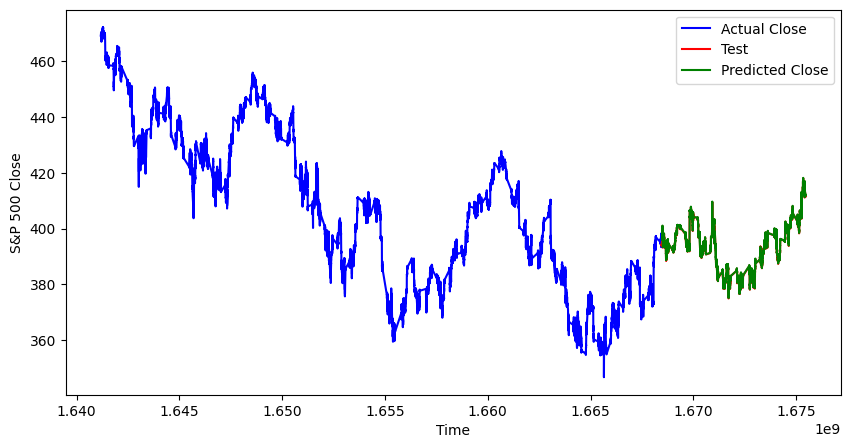

In [23]:
import matplotlib.pyplot as plt

sample_ratio = 0.005
first_n_rows = int(len(res_df)*sample_ratio)
print(f"{first_n_rows=}")

plt.figure(figsize=(10, 5))
plt.plot(train_labels.index, train_labels["close"], label="Actual Close", color="blue")
plt.plot(test_labels.index, test_labels["close"], label="Test", color="red")
plt.plot(res_df["predicted_close_price"], label='Predicted Close', color="green")
plt.xlabel("Time")
plt.ylabel("S&P 500 Close")
plt.legend()
plt.show()

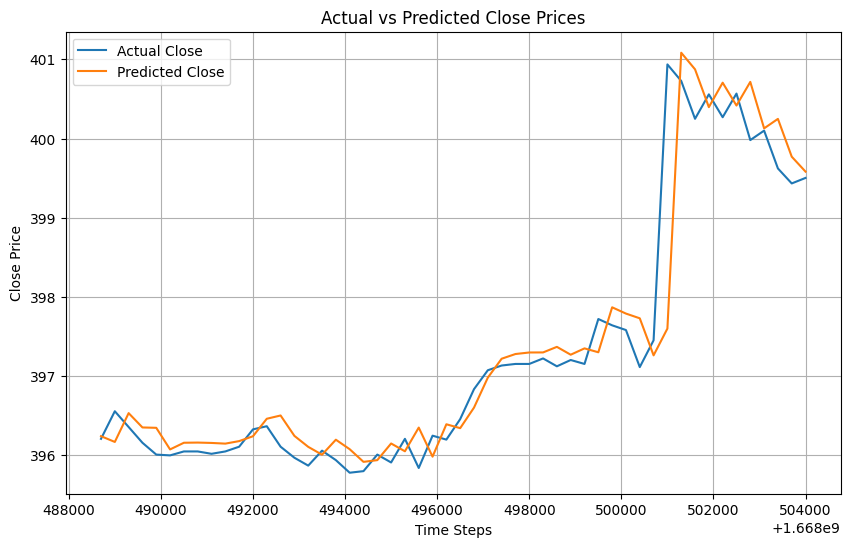

LSTM Training complete!


In [24]:
# 11. Plot the actual vs. predicted close values
plt.figure(figsize=(10, 6))
plt.plot(res_df.iloc[:first_n_rows]["close"], label='Actual Close')
plt.plot(res_df.iloc[:first_n_rows]["predicted_close_price"], label='Predicted Close')
plt.xlabel('Time Steps')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Prices')
plt.legend()
plt.grid(True)
plt.show()

print("LSTM Training complete!")

